In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Read QDM data

First, we create a read the observation points.

In [2]:
nc_file = "NRM6.mat"
data_dir = pathlib.Path("")/"real-data"
data = mg.load_qdm(data_dir / nc_file)

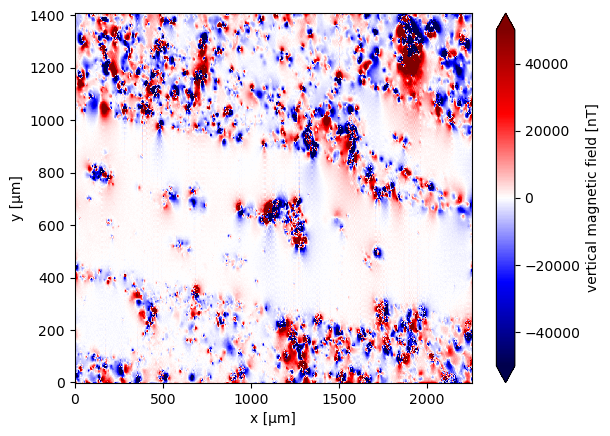

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

In [4]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 7.067e+03 8.284e+03 ... 481.8 2.181e+03

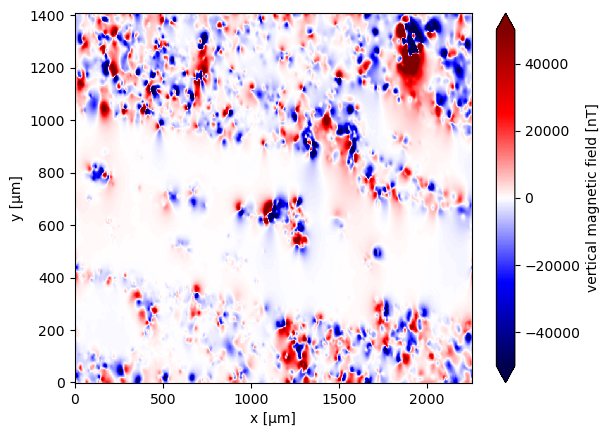

In [7]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [8]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 7.067e+03 8.284e+03 ... 481.8 2.181e+03
    tga      (y, x) float64 5MB 2.294e+03 2.675e+03 ... 1.185e+03 1.363e+03
    x_deriv  (y, x) float64 5MB 518.1 75.68 -657.2 ... -66.18 436.0 723.1
    y_deriv  (y, x) float64 5MB 657.5 630.4 411.4 ... 1.086e+03 1.115e+03
    z_deriv  (y, x) float64 5MB -2.135e+03 -2.599e+03 ... 185.0 -303.9

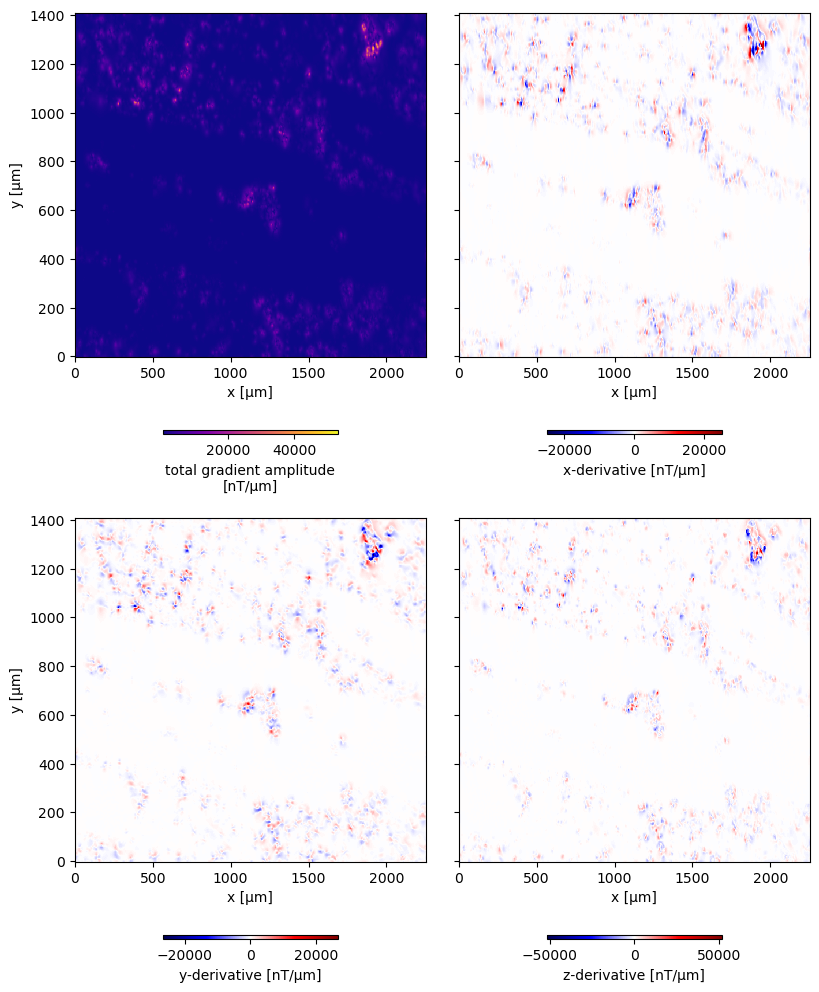

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [10]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

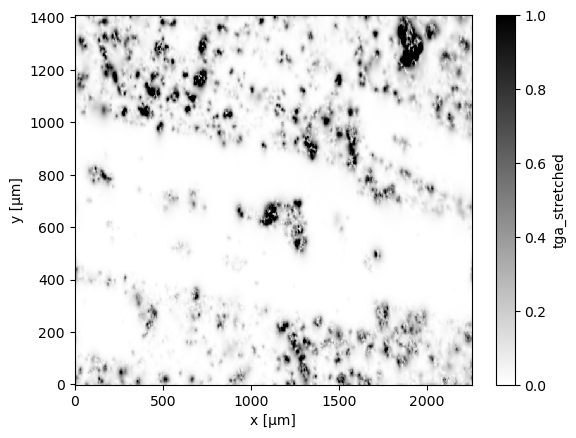

In [11]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [15]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 100],
    size_increment=1.0,
    threshold=0.05,
    overlap=1.0,
    exclude_border=30,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [16]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

445 potential sources detected within 1.7823 seconds


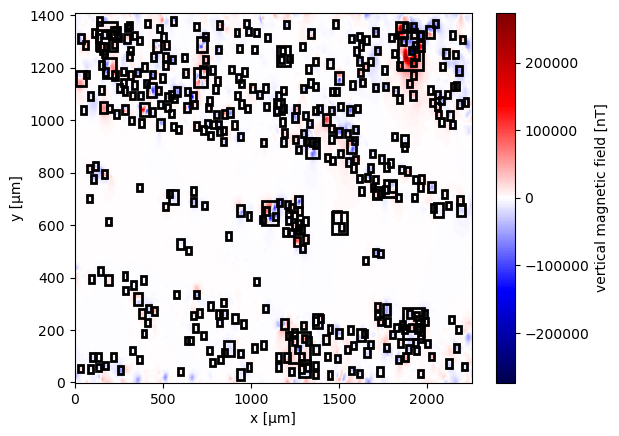

In [17]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [18]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [19]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

445 euler positions and dipole moments estimated within 3.0474 seconds


# Iterative Euler deconvolution

In [20]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [21]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [22]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [23]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 105.3219 seconds


In [24]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x        y     z           bz      z_deriv
0  1478.15  1139.75  10.0  1970.863674 -1715.243163
1  1480.50  1139.75  10.0  2130.810653 -2120.498565
2  1482.85  1139.75  10.0  1380.572022 -2433.649953
3  1485.20  1139.75  10.0  -868.048313 -2340.601288
4  1487.55  1139.75  10.0 -4726.673597 -1796.267724

In [25]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

In [26]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

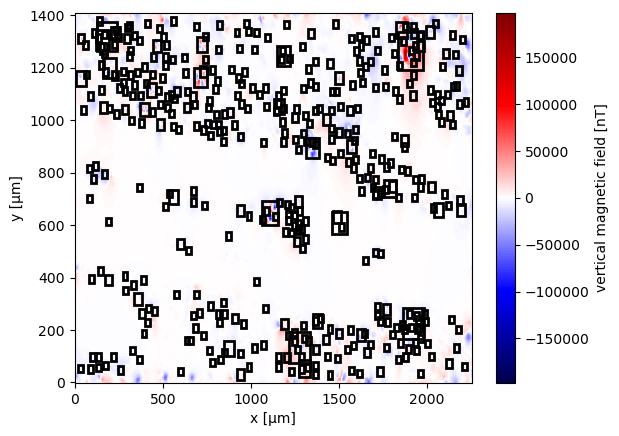

In [27]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

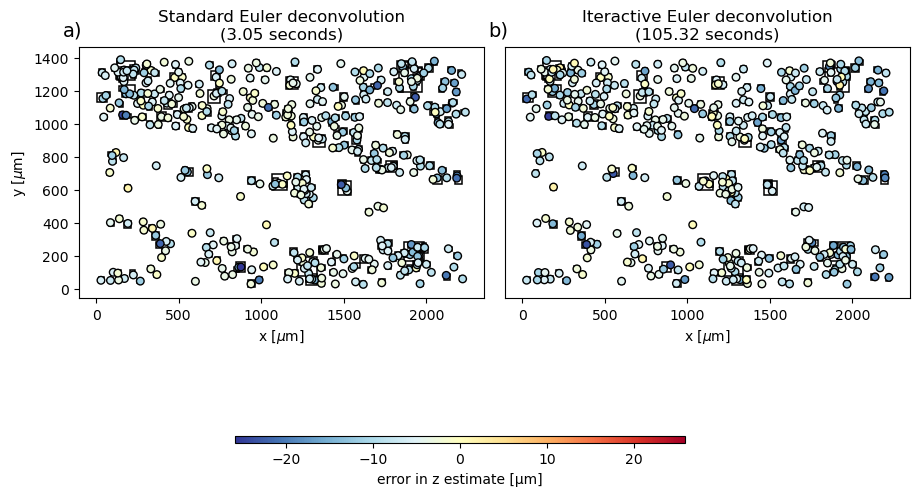

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [29]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

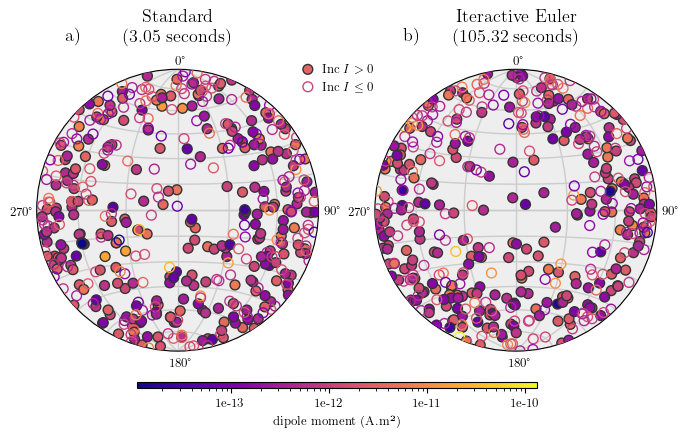

In [30]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

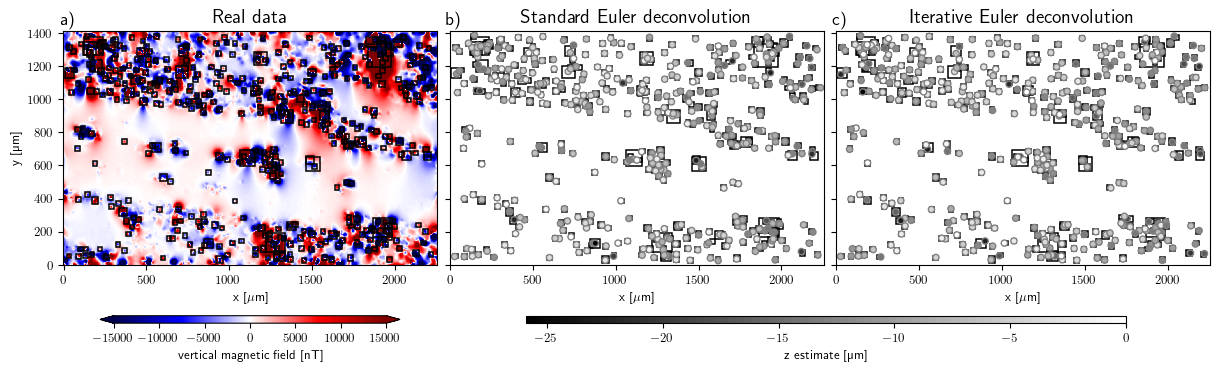

In [31]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


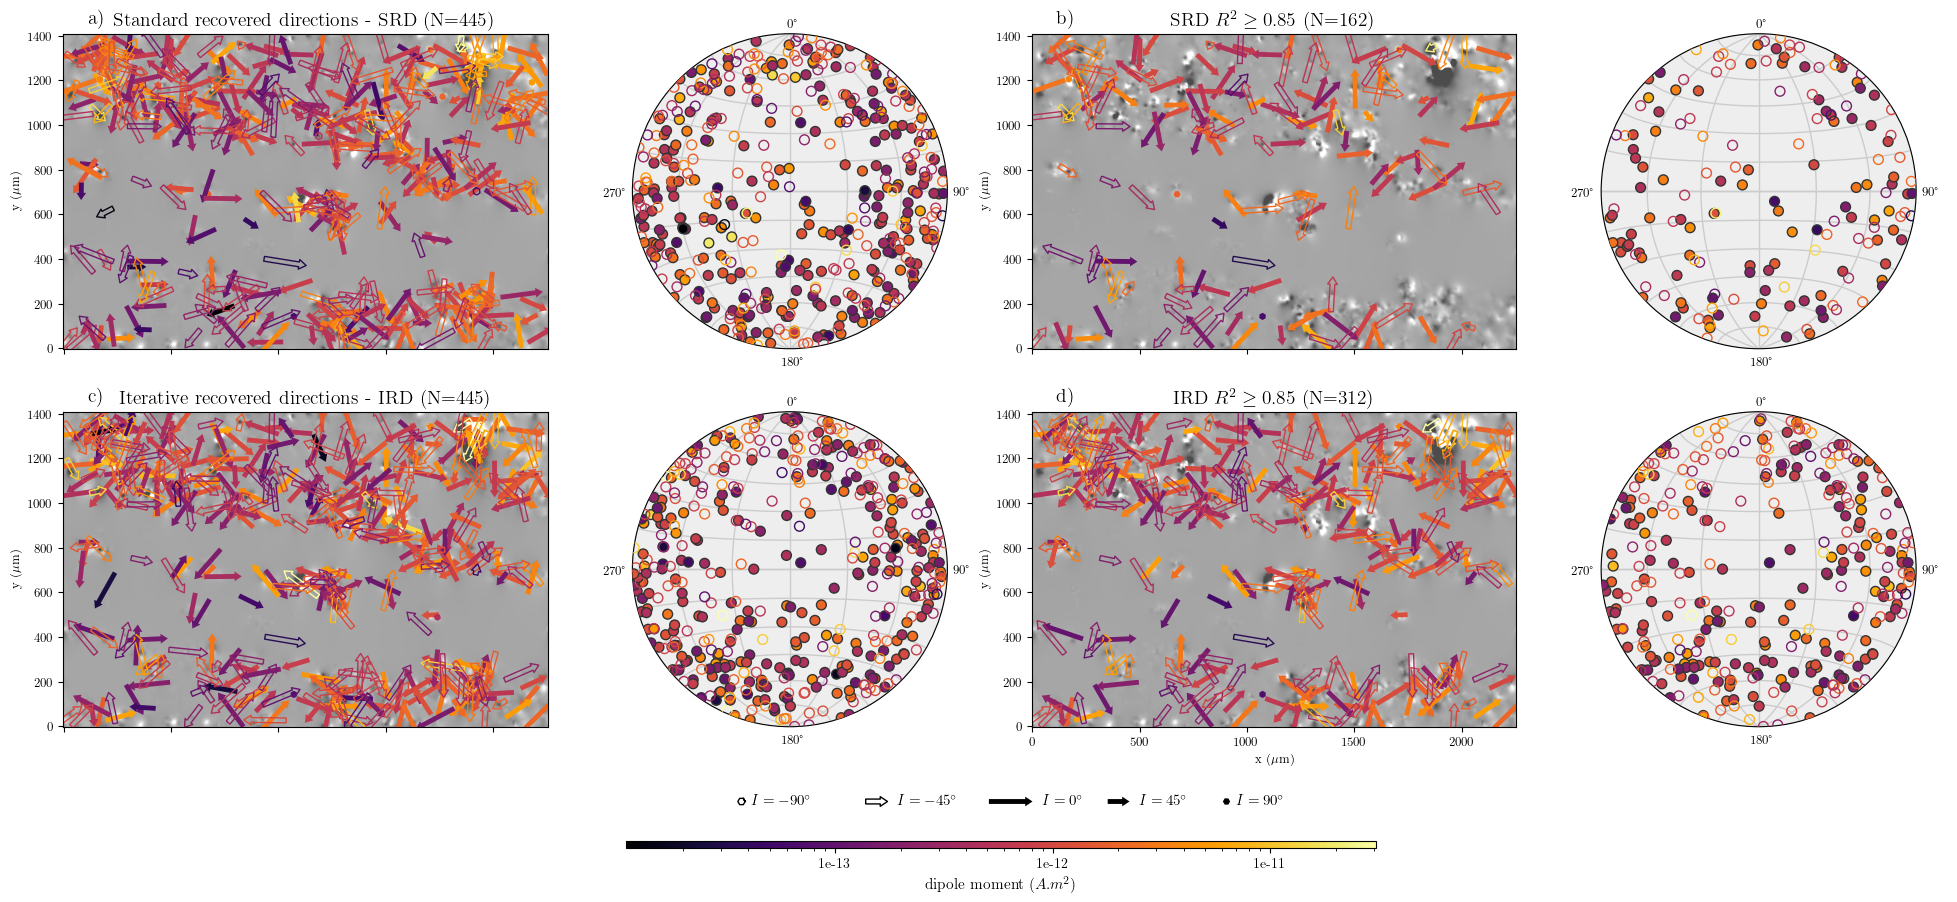

In [32]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

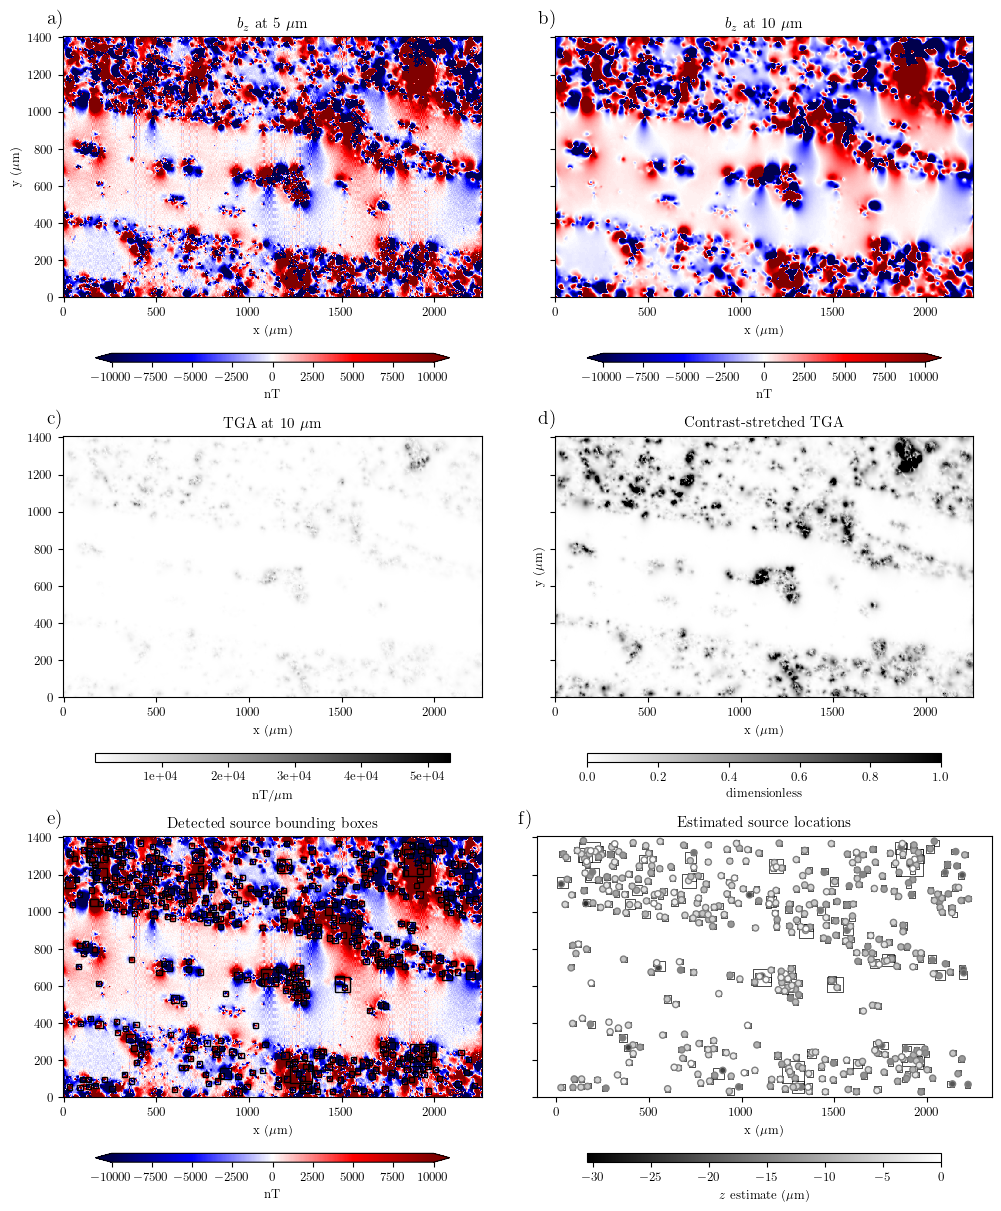

In [33]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [34]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [35]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 7.356e+03 8.63e+03 7.809e+03 ... 630.2 2.365e+03
    tga      (y, x) float64 5MB 2.304e+03 2.688e+03 ... 1.202e+03 1.378e+03
    x_deriv  (y, x) float64 5MB 542.1 96.32 -642.4 ... -58.24 448.5 738.2
    y_deriv  (y, x) float64 5MB 685.7 666.3 453.0 ... 1.096e+03 1.129e+03
    z_deriv  (y, x) float64 5MB -2.132e+03 -2.602e+03 ... 205.7 -285.0

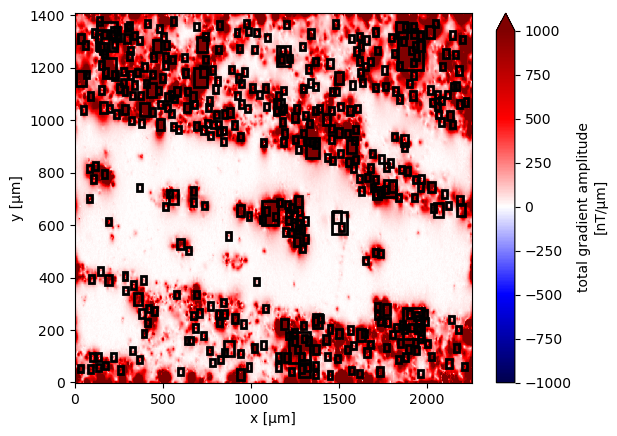

In [36]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [37]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [38]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.025,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [39]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

455 potential sources detected within 1.3288 seconds


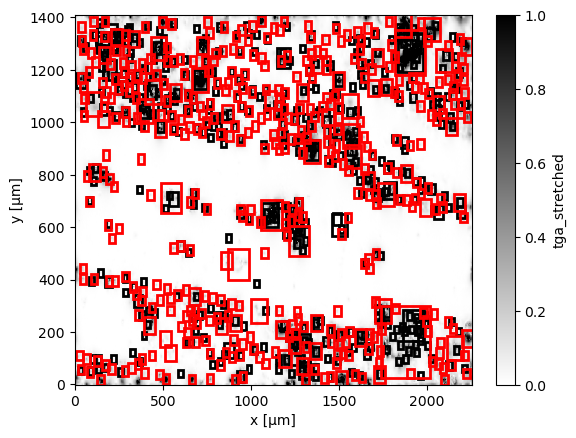

In [43]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [44]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[1041.46522369 1078.23477631 1368.11522369 1404.88477631]
[6.46665224e+02 6.83434776e+02 4.15223689e-01 3.71847763e+01]
[498.61522369 535.38477631   2.76522369  39.53477631]
[1484.08732969 1547.41267031  -10.51267031   52.81267031]
[2203.18732969 2266.51267031  144.58732969  207.91267031]
[127.31522369 164.08477631  -1.93477631  34.83477631]
[ 2.08251522e+03  2.11928478e+03 -1.93477631e+00  3.48347763e+01]
[2214.11522369 2250.88477631 1001.51522369 1038.28477631]
[1433.91522369 1470.68477631 1050.86522369 1087.63477631]
[750.06522369 786.83477631   2.76522369  39.53477631]
[1487.96522369 1524.73477631  132.01522369  168.78477631]
[1217.71522369 1254.48477631  209.56522369  246.33477631]
[2195.31522369 2232.08477631 1093.16522369 1129.93477631]
[ 470.41522369  507.18477631 1008.56522369 1045.33477631]
[2178.86522369 2215.63477631 1227.11522369 1263.88477631]
[1683.01522369 1719.78477631  162.56522369  199.33477631]
[188.41522369 225.18477631  40.36522369  77.134

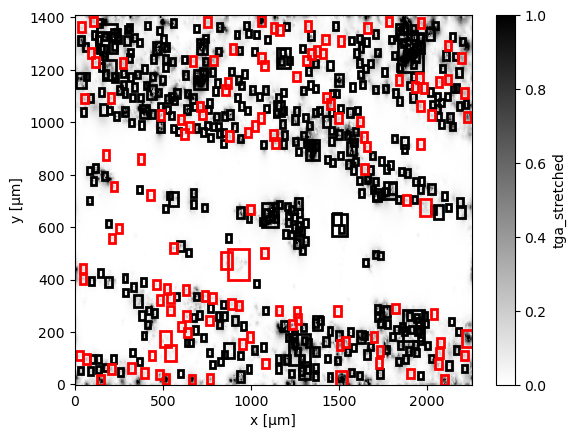

In [45]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [46]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[1061.96304181 1388.13908054   -2.40135785]

[ 7.74056553e-13  2.73761873e-13 -5.44458203e-14]

(3.793907134752047, 70.52275573920457, 8.228447343280651e-13)

0.8608882966806135

[665.55648103  19.34414334 -11.99144475]

[-7.58614214e-14  1.84259870e-13 -2.36526310e-12]

(85.18439887803324, -22.377399225598573, 2.373641969247714e-12)

0.9928831311569858

[518.6094362   17.11173769 -12.03126327]

[ 1.77309347e-12 -9.43727943e-13 -2.82657247e-12]

(54.60186244326653, 118.02411390452326, 3.4675632377457188e-12)

0.9518065263792623

[1521.3152064    17.09112045   -5.20726062]

[-1.42389502e-12  2.67588682e-13 -4.97599883e-13]

(18.95512235272794, -79.3566980921104, 1.5318898068660706e-12)

0.5890595242003198

[2232.07804939  179.52471177  -17.1939634 ]

[-3.02738121e-12  5.12871652e-12 -4.03977912e-12]

(34.14982546131693, -30.552523789183276, 7.196428659859996e-12)

0.9822537913353384

[148.03263304  17.80462688  -8.84556845]

[ 1.95303427e-12 -8.23082933e-13  2.03569600e-14]

(-0.5503153029880656, 112.85240844206639, 2.1194864460688373e-12)

0.9060611492231133

[2103.06373611   10.60862331  -11.01796752]

[-9.24495802e-13  1.72438917e-12 -2.00220370e-13]

(5.8428384202718675, -28.19706926166517, 1.9667991022204185e-12)

0.9129268717130044

[2245.50981372 1018.31263511  -14.08244199]

[ 2.69229369e-12 -2.32480641e-12 -3.07672679e-13]

(4.943475125583521, 130.8107401904242, 3.570410708509369e-12)

0.8377858492151965

[1456.99524415 1075.03858628   -4.47565244]

[ 9.50175726e-14  3.05852727e-13 -9.98296130e-14]

(17.312385921193997, 17.258162640572962, 3.35470090084038e-13)

0.710221486453374

[763.95374321  18.23224247  -8.02431208]

[-3.02724206e-13 -3.25237578e-13 -1.52875488e-13]

(18.986555862505597, -137.05326022067564, 4.698854563418571e-13)

0.9225014146537645

[1500.2634347   146.6105655    -7.88565254]

[-2.16080967e-13 -4.21998451e-13 -4.00269480e-13]

(40.173294500059185, -152.8856430919977, 6.204750870386941e-13)

0.7629160847979461

piorou

[1239.51388961  222.83698436   -1.31838745]

[-2.88062889e-14 -3.67609792e-14  1.47803330e-14]

(-17.56127235868955, -141.91737817144687, 4.89860195967761e-14)

0.11430276205750034

[2209.23346249 1113.52891312  -16.18967733]

[-1.49182338e-12  4.77943579e-13 -7.98781844e-13]

(27.01750473949348, -72.23581727924369, 1.7584139157033107e-12)

0.9661992212141156

[4.88553741e+02 1.02615838e+03 9.55583547e-01]

[4.18906816e-14 1.70225410e-14 6.94631756e-15]

(-8.733565310184947, 67.88532565548927, 4.574764952108069e-14)

0.7274559363330455

[2207.92925292 1246.29864572  -19.17422355]

[ 2.62292589e-12  2.99041307e-12 -9.47965641e-13]

(13.404599500579721, 41.25437522698031, 4.089125751568596e-12)

0.9676242749310974

[1702.5618385   181.39609796  -13.72699483]

[ 7.61981582e-13  2.91704043e-14 -8.17258366e-13]

(46.983730687051874, 87.80765658490907, 1.1177558233072147e-12)

0.9511673621802551

[204.78356331  56.76576873  -9.76260878]

[-3.56478632e-13  2.06204957e-14 -2.55117823e-13]

(35.54453956843984, -86.6894165294736, 4.388477222748465e-13)

0.827402135926724

[869.59456984 948.11967058 -14.79608652]

[ 1.03474157e-12 -2.52057704e-13  3.26753126e-13]

(-17.056573296842508, 103.69032509478129, 1.1139976682727115e-12)

0.8876905855802864

[ 795.98240786 1249.11472027  -25.55773594]

[-4.93909063e-12 -1.28071531e-12 -2.34388555e-12]

(24.672443117495515, -104.536741371078, 5.6150376211087135e-12)

0.8050764983780464

[1535.99281087  170.13207245  -21.31498256]

[ 1.53841340e-12 -2.62377206e-12 -8.49560930e-14]

(1.5999719423590755, 149.61534657947277, 3.042714764899812e-12)

0.7643932173503123

[2073.6083777  1151.27189841   -7.77081377]

[ 1.70914767e-13 -1.00212300e-13 -1.38571600e-13]

(34.96922888698094, 120.38433635801066, 2.4177768954947354e-13)

0.9619805490907699

[ 120.63074326 1220.51777575  -11.90474025]

[ 2.85153935e-13 -3.48633152e-13 -2.31578939e-13]

(27.210676422578693, 140.7195891671148, 5.064451069581204e-13)

0.8295735064530831

[ 68.01007765 101.42741638  -3.28723279]

[-1.01470264e-13 -1.52711410e-14  1.39282657e-14]

(-7.729853799358646, -98.55870723654654, 1.0355394132717852e-13)

0.7453432827150939

[1656.52326104  903.86814118   -6.04230195]

[-2.93644426e-14 -1.14028675e-13 -7.82398936e-14]

(33.6025976122114, -165.5590647855864, 1.4137287650285626e-13)

0.964817292222769

[ 105.67555055 1391.30226677   -7.46642269]

[ 1.33609229e-13  3.48185489e-13 -1.58186682e-13]

(22.984749744283807, 20.99330792180624, 4.0510194688273793e-13)

0.8924104499083827

[1962.15992987 1057.62687085  -18.98463015]

[-1.33474358e-12  7.71641814e-13  8.37061840e-13]

(-28.498957681410634, -59.96693892291921, 1.7543215311248041e-12)

0.9610913004204206

[931.24984906 306.1894044   -1.16378277]

[-6.94166178e-15  4.54468899e-14 -1.45262179e-14]

(17.53477012929155, -8.684367327827339, 4.821428705286154e-14)

0.6001697031657773

[631.59657057 357.97956287  -4.27928749]

[-8.01176585e-14 -2.41091540e-14 -4.22546963e-16]

(0.2893623998045581, -106.74768894287685, 8.366761052051592e-14)

0.7076643664242914

[ 41.45933485 402.93452919  -1.23442246]

[ 6.22145841e-14  2.89324231e-14 -1.74009897e-15]

(1.4527714051013731, 65.05957216823815, 6.86350313172844e-14)

0.7112172454545842

[ 713.85178951 1064.34514344  -14.62377289]

[-6.20666700e-13  1.66952301e-13  5.60218127e-13]

(-41.076205265725136, -74.94444717334832, 8.52610446417509e-13)

0.9552171716921249

[1744.758962    130.84782743  -16.71916392]

[-1.95381887e-12  3.05155204e-13  6.26271827e-13]

(-17.57288511095567, -81.12303351987565, 2.074305738058347e-12)

0.9668382747811416

[481.66204459  29.43490813  -5.23945538]

[1.57512972e-14 2.44818720e-13 8.64882526e-14]

(-19.4198857006792, 3.681257190655864, 2.6012406017698414e-13)

0.6883937950390243

[2066.01375228   72.45365479   -2.68886896]

[ 8.60026743e-14  7.48937099e-15 -7.83940565e-14]

(42.242391352850746, 85.023066990279, 1.1661122908023808e-13)

0.7775079642388485

[2082.25690607  162.85103169   -6.97799287]

[-9.64758811e-14 -1.77430455e-13  8.60430759e-14]

(-23.075618989889843, -151.46534405865094, 2.1952806826436975e-13)

0.8090448044337974

[1342.56240913 1260.98818863   -2.86608328]

[-6.02873042e-14 -8.03430344e-14  6.55343496e-15]

(-3.732848705399028, -143.11639957036638, 1.0066036829317614e-13)

0.8421536720305464

[1144.68403943  921.86437213  -10.39258708]

[-2.15619355e-13  3.32256987e-13  1.57190392e-13]

(-21.645967183675218, -32.981698732243686, 4.2613991980113547e-13)

0.8622481158837946

[ 265.82239907 1236.4849963   -27.19099948]

[-3.23696075e-12  3.45193515e-12 -2.39538352e-12]

(26.847963985922192, -43.15920482188978, 5.303926227017557e-12)

0.9253844433362817

[1061.80806887 1248.79251681   -9.9667217 ]

[ 1.10948874e-14  1.81880868e-13 -1.82272759e-13]

(45.00845802962143, 3.4907656663026883, 2.5773456363281765e-13)

0.9358015988959103

[ 896.63263142 1283.83941741  -14.43833234]

[ 7.85263417e-13 -2.34927507e-13  1.54338231e-13]

(-10.66377623033337, 106.65562218249379, 8.340562676818325e-13)

0.9619398719155217

[2079.01360324  120.74921443   -9.38259664]

[ 2.18001472e-13 -3.45462156e-13  1.58979207e-14]

(-2.228724261816576, 147.74631271501306, 4.0880494984628013e-13)

0.7758195194451002

[565.92361398 520.41168247  -8.55380175]

[-2.75767564e-13 -1.12197740e-13  1.04824122e-15]

(-0.2017329303005962, -112.13925406575436, 2.9771997069798e-13)

0.912038842972937

[1272.30834593  240.77685985   -9.45934305]

[ 1.54531761e-13 -3.07898577e-13 -9.65002337e-14]

(15.648366724852558, 153.34830219973995, 3.5776234297686994e-13)

0.8272716060007445

[1825.39854832  283.99677786   -6.75862565]

[-1.80757644e-13 -1.11624873e-13 -8.68716893e-15]

(2.341584348072349, -121.69694268604621, 2.126238581708785e-13)

0.8500185127878321

[ 756.1674314  1381.79885434  -21.26759444]

[-2.68350916e-12  2.73414200e-13  2.67656636e-13]

(-5.666771111229614, -84.18239081900114, 2.7106487772009144e-12)

0.9654750690787396

[1992.89214347  674.94701623  -23.93511156]

[ 2.08417396e-12  1.92420074e-12 -3.17481136e-13]

(6.386133408708204, 47.285447219181655, 2.854316706419948e-12)

0.9015514917487822

[2211.23533214  117.30555858  -11.06920125]

[ 4.69064758e-13 -3.00239314e-13  1.12226017e-13]

(-11.393104371555319, 122.62252452065691, 5.681197689715669e-13)

0.8307729302989968

[2121.45524974 1159.04385311  -14.90684223]

[5.24996525e-13 1.10016481e-12 2.83432358e-14]

(-1.3319464315717375, 25.51038641099845, 1.2193388776474092e-12)

0.9618724872781492

[ 207.11141881 1104.73375202   -9.66200636]

[-2.99723014e-13 -2.64325689e-13  1.83545469e-14]

(-2.6296992572618407, -131.4090668577969, 4.0004855246040856e-13)

0.7581544050741298

[1423.65480459 1319.4248503    -3.64867895]

[ 3.20112375e-15 -9.11329076e-14  1.66723126e-14]

(-10.36108031849946, 177.9882623253211, 9.270070146207857e-14)

0.9334570663198031

[1262.91405537 1174.59938443   -5.70020335]

[-9.70137792e-14 -2.13507742e-15  4.26495634e-14]

(-23.726321624309538, -91.26076090941471, 1.0599630729506084e-13)

0.9801356395317121

[  60.45769101 1085.90472644  -21.93471338]

[-1.57956673e-12 -1.04270581e-12 -3.09086881e-13]

(9.274862043673341, -123.42965642016979, 1.917759412072073e-12)

0.8075725760759459

piorou

[2040.32072821 1013.38591834   -4.38827264]

[ 7.45276160e-16  7.19896981e-14 -5.50941677e-14]

(37.425575092064406, 0.5931356044450974, 9.065560869742941e-14)

0.30525516246280004

[983.8933998  954.47659708  -9.9078841 ]

[ 2.19605917e-13 -1.94730597e-13 -7.28169193e-14]

(13.933309366922071, 131.56428507435203, 3.024054692714442e-13)

0.8842628715553671

piorou

[1671.05300196 1379.07423379   -8.74199201]

[-4.38208431e-13  2.91758028e-15 -6.28610263e-14]

(8.163213390069206, -89.61853183372429, 4.4270379443783293e-13)

0.3807826222906613

[ 2.13596096e+02  5.59747347e+02 -5.38201064e-01]

[ 1.96395935e-14 -2.19692984e-15 -9.65310020e-15]

(26.03391755843482, 96.38270254263362, 2.199369176355905e-14)

0.6448859132597108

[547.51991937 284.69634455  -4.9247999 ]

[-1.14653874e-15  5.04730805e-14 -5.36921392e-14]

(46.76269527716756, -1.3012983289742792, 7.370001505186053e-14)

0.8275069160685642

[2128.63673533 1289.63845766  -17.12496732]

[-1.68601454e-12  2.16372804e-13  2.01673670e-13]

(-6.766092439442015, -82.68698240139638, 1.7117635627957575e-12)

0.9177487594718393

[1968.7232778  1370.79937542  -30.9519771 ]

[7.47575852e-12 3.52614174e-12 1.14935136e-13]

(-0.7966572093429618, 64.74783624888438, 8.266429157433994e-12)

0.8739377181105542

[1500.05572142 1014.33168207   -5.58913887]

[ 1.03938886e-13  1.36126728e-13 -8.76473872e-15]

(2.929536529450061, 37.36336342178426, 1.7149518593023077e-13)

0.8575872222731763

[216.69254672 761.02019278 -11.7867378 ]

[-2.63805312e-13 -6.31873673e-14  3.48406928e-13]

(-52.09592567583855, -103.46987401891502, 4.415577801332453e-13)

0.9297585244532491

[ 609.18479819 1004.80946288   -8.28523854]

[-2.71713095e-13  6.31062402e-14  5.51786387e-14]

(-11.189328201096854, -76.92468247577607, 2.8435028695404475e-13)

0.741325363126304

[654.71173377 982.89892999  -8.9412295 ]

[ 2.99383758e-13 -8.27474668e-14 -2.14346801e-14]

(3.9476443017261573, 105.45040709099999, 3.113474315174406e-13)

0.8634576971827617

[1934.60773447 1132.61509744  -21.71836099]

[-1.09236887e-13  2.17144924e-12 -2.36121171e-13]

(6.198124595283079, -2.8798927352013193, 2.1869791236433054e-12)

0.9756980339391893

[1620.10261732  992.38355747  -28.78458017]

[ 3.91940026e-12 -8.28113505e-14 -1.00948915e-12]

(14.440216419222835, 91.21039820033721, 4.048163100813619e-12)

0.9191331173790224

[1878.59186755  708.2026078    -9.52032926]

[-2.32063918e-13  2.35807655e-15 -1.57023112e-13]

(34.08237651320208, -89.41781908542083, 2.8020613867039783e-13)

0.8254682363427506

piorou

[869.32455468 471.05725485  -1.94645376]

[ 5.20155627e-14 -2.69966160e-14 -2.31444611e-15]

(2.2616029046291466, 117.42978028116914, 5.864974598036599e-14)

0.19021124437080505

[ 1.15676272e+03  1.35304947e+03 -1.10917077e+00]

[3.21749041e-14 3.69500780e-15 2.11330153e-14]

(-33.12556865912359, 83.4487779304352, 3.867146064465681e-14)

0.8270506961918098

[1323.10690995 1367.85539195  -16.30216074]

[3.58633675e-15 8.23708074e-13 1.41190168e-13]

(-9.7263440944069, 0.24945811229423248, 8.357287336491617e-13)

0.9270137196024183

piorou

[ 6.60305143e+02  1.22750721e+03 -5.50196777e-03]

[ 3.99025369e-14 -9.14051524e-15 -2.39686210e-14]

(30.34955108397426, 102.90220241452319, 4.743686607982029e-14)

0.3792576750185903

[522.54914269 358.3013153   -4.69445344]

[-2.68754383e-14 -5.80603357e-14 -2.42133563e-14]

(20.729591012225196, -155.1611434003772, 6.840744397508168e-14)

0.7242544727459099

piorou

[1873.02961013 1162.32279611  -21.12214787]

[4.19704316e-12 7.92488982e-13 5.60949352e-12]

(-52.713457639686325, 79.30725698607645, 7.050505486835941e-12)

0.8527387720024135

[1646.29860366  818.56228538  -13.36831602]

[-4.12945140e-13  6.66245901e-13 -2.60034237e-14]

(1.9000531174228632, -31.791003207367677, 7.842725722833368e-13)

0.9536779175811907

[1635.07986977  943.5392112    -4.64967735]

[1.06617958e-13 6.28835053e-14 3.50830755e-14]

(-15.824252341724115, 59.46780296900076, 1.2865669972108357e-13)

0.8502795699855858

piorou

[371.33014338 863.70181437  -1.07581571]

[-1.53139289e-14  1.21133977e-14 -7.74828478e-15]

(21.644467724975268, -51.65581925365615, 2.100682603910611e-14)

0.5650361257973865

[ 9.90459285e+02  1.77088123e+02 -7.96101182e-01]

[ 5.59882263e-15 -2.90442218e-14 -8.15778875e-15]

(15.418707731881678, 169.0889923832695, 3.068327150674251e-14)

0.7319111198740789

[733.53399909 335.33328686 -12.48935192]

[-4.40876099e-13  1.81653280e-13  4.20314504e-14]

(-5.037438094885611, -67.60696945340848, 4.786818272124342e-13)

0.9287147725703251

[893.88949339 315.47103113 -13.39251304]

[ 3.67703573e-13  1.84037642e-13 -2.41028057e-13]

(30.377743942707706, 63.411785417618304, 4.766238508599559e-13)

0.8982936171885477

[1138.33923997  952.29625181   -7.72124875]

[-2.99851895e-13 -2.36486384e-13  1.06788434e-14]

(-1.6017689666548953, -128.26204283954888, 3.8203534708573153e-13)

0.926590701334483

[643.33018527 259.45213489 -11.11751698]

[ 2.24796130e-13 -8.67865386e-14 -9.31631202e-14]

(21.137575640082165, 111.10996718450997, 2.583497055010247e-13)

0.7838544379278759

[1783.34463875 1383.71750296  -11.46559318]

[3.48515338e-13 2.57800293e-13 5.09181078e-14]

(-6.699130918861555, 53.50929551167992, 4.36482056812981e-13)

0.959480032636039

[1074.91596332  501.89642821   -4.61265669]

[-5.15408665e-14 -8.37879135e-15 -1.38571176e-14]

(14.86220312207436, -99.23356919462834, 5.402485325070251e-14)

0.9794186964355978

[1966.63609702  916.82754652   -6.39878292]

[-8.57212858e-14  7.68601135e-16  1.54801988e-14]

(-10.236176413290414, -89.48628370791948, 8.711122857955065e-14)

0.9626043594352309

[541.21774512 329.0344503   -2.1463949 ]

[ 1.57684445e-14 -1.80556208e-14 -2.47468610e-14]

(45.91138471417072, 138.86843979901224, 3.445368510097136e-14)

0.7930688799088167

[476.62950535 314.48795381 -12.56267435]

[ 2.76860576e-13  2.33095733e-13 -1.38528367e-13]

(20.944878876288936, 49.90514907075758, 3.875248476823862e-13)

0.8955408898340358

[1432.7686627  1094.0527755    -6.50328227]

[ 1.63408032e-13  1.33361987e-13 -7.54592665e-15]

(2.0489460065314105, 50.781128190228955, 2.1105578810434478e-13)

0.9196011787786115

[1080.26016344 1221.52893841  -12.17098796]

[ 8.78402317e-14  1.00461876e-13 -2.10661918e-13]

(57.64687738168746, 41.16527477840078, 2.4937309119601114e-13)

0.9779163019235192

[1521.95053207 1309.41397813  -10.38863235]

[-2.32237576e-13  1.18565448e-14  5.13074650e-14]

(-12.442350556561285, -87.07738647733726, 2.3813299937384253e-13)

0.8538213672095727

[  36.97420843 1371.825328    -12.64353217]

[ 4.54193340e-13 -3.00372494e-13  9.61380380e-14]

(-10.012483386383908, 123.47793125741343, 5.52953658235033e-13)

0.8701367387194443

[298.30804338  64.94191289 -14.37168864]

[ 1.28853948e-12 -9.57167451e-13 -5.23236624e-13]

(18.05461414530846, 126.60612038214941, 1.688277256586253e-12)

0.7805580270237993

piorou

[1739.50834031   77.37357114   -4.24056823]

[-9.60173826e-14  6.49526212e-15 -4.26680187e-16]

(0.25402764622699686, -86.1300236963431, 9.623776936812027e-14)

0.5847949497549374

[ 874.10394456 1150.20973717   -6.52019088]

[ 1.04876852e-13  6.22786564e-14 -1.40027424e-14]

(6.548917530987908, 59.29703581874758, 1.227756566368147e-13)

0.9001134072866458

[ 42.79583896 440.63326685  -2.95804644]

[ 2.21447011e-14  7.18199590e-14 -1.48017549e-14]

(11.141575197557344, 17.136430241792805, 7.660017134656189e-14)

0.8229264502132932

[ 26.97484735 112.58027991 -11.97227077]

[ 1.81831421e-13  2.27461039e-13 -6.77212294e-14]

(13.091669402843484, 38.638696748528666, 2.9897718113520637e-13)

0.9132943020450028

piorou

[1977.13153476 1148.13664376  -44.9193729 ]

[-1.29331297e-11  2.08810670e-11 -8.94747251e-12]

(20.01583401289342, -31.77287802177742, 2.6140812269388763e-11)

0.7946196656844664

piorou

[ 1.16007748e+03  2.76580963e+02 -4.28791798e-01]

[ 3.67706245e-16 -1.12177132e-14 -1.73815992e-14]

(57.148646749492904, 178.12256965753727, 2.06903911936869e-14)

0.6318495952120405

[436.51108228 111.84352836  -1.75034129]

[-7.06664291e-15  6.66853647e-15 -2.06342313e-14]

(64.78503177626554, -46.660221077175656, 2.280741809161534e-14)

0.9130217554907815

[ 730.50585931 1028.07103973  -10.48525191]

[ 4.50567531e-14  1.68267662e-13 -1.35851577e-13]

(37.94993338972359, 14.99033184525325, 2.209066947410694e-13)

0.7472758986245353

piorou

[1088.97910937   79.47758023   -3.10637148]

[ 3.94129108e-14  3.71022231e-16 -8.00696612e-15]

(11.483197389231949, 89.46064932641292, 4.021973030236981e-14)

0.7705200909566278

piorou

[1367.54105303 1266.380037     -7.41619433]

[-1.20683515e-13 -1.11593456e-13  5.69669168e-14]

(-19.115119933502218, -132.75889808215402, 1.7396217895228577e-13)

0.49312377865025925

[1493.16626228  280.00621974   -1.69613469]

[-1.19208556e-14 -1.75084632e-14  1.87469831e-15]

(-5.057879958230576, -145.75052022281892, 2.1264232324188527e-14)

0.9053592200996169

piorou

[1053.56725545 1010.58790626   -3.92211592]

[4.26346427e-14 6.17794485e-15 5.97623177e-15]

(-7.897910221272842, 81.75498077403094, 4.34924718123886e-14)

0.35469208622113035

[2037.35043136  263.61354679   -7.37217689]

[-2.39002785e-14 -1.07417985e-13 -1.51247619e-15]

(0.7874346256163279, -167.45614012688492, 1.1005514287898343e-13)

0.9118541781982242

[462.8161293  379.2681295   -2.43956748]

[2.30994489e-16 7.45862373e-15 1.87779138e-14]

(-68.32750424370367, 1.7738903042949603, 2.020629787762404e-14)

0.9519014300000401

[175.15692773 870.56508397  -9.32543991]

[ 4.89907816e-14 -1.72388375e-13 -3.19522984e-14]

(10.109087703254218, 164.13546363453355, 1.8204064926651183e-13)

0.9882836521969045

[781.09714801 333.9689068   -8.21450456]

[-5.90025517e-14  9.15106992e-14 -2.91015767e-14]

(14.963889836871184, -32.812354165375105, 1.1270497301565544e-13)

0.7930738852402497

[908.51592107 468.92803447 -18.29623583]

[-1.98024692e-13 -4.13609574e-13 -1.49363217e-13]

(18.041208166084328, -154.41620453411514, 4.822821050102911e-13)

0.3759686312204078

[954.6813521  153.14816994  -3.94394892]

[ 4.43087079e-14 -5.75305220e-14 -1.45694554e-14]

(11.345084930133611, 142.39734839353366, 7.406275442397415e-14)

0.8432264791784951

piorou

[1984.08579241 1139.83185031   -8.08035641]

[-2.50386723e-14 -2.97684980e-13  3.04428936e-13]

(-45.54075313450953, -175.192094051838, 4.2652111282062823e-13)

-2.063021686370453

[  87.01272681 1264.21901305  -15.92989808]

[-8.73827655e-13 -3.38978246e-13  9.82889713e-14]

(-5.98655223571689, -111.20244135763264, 9.424127244170517e-13)

0.9320077552591102

[1261.44501727  275.12615895   -2.40240005]

[ 2.49076385e-14 -1.47289339e-14  2.02829410e-14]

(-35.02822817785837, 120.59760980181396, 3.5337368941061385e-14)

0.9227071393149208

[994.86068874 657.37676079 -15.05138293]

[-3.95535673e-13 -5.40528286e-13 -1.30176445e-13]

(10.998546162278316, -143.80491691970641, 6.82323386472824e-13)

0.9217614600933743

[628.3997136  956.17519913  -8.22020147]

[1.51640193e-13 3.68062086e-15 3.24439667e-14]

(-12.073111560083913, 88.60958603379117, 1.5511578324480722e-13)

0.8978697216939401

[1133.19207113 1363.43558365  -12.32029505]

[ 2.68596168e-13 -3.54432565e-14 -1.95997960e-13]

(35.8835212446517, 97.51717226408825, 3.3438798717963533e-13)

0.9030872783407209

[602.9071803  228.46924751 -13.48434548]

[-2.31345422e-13  1.56027752e-13 -1.51921140e-13]

(28.56542031267373, -56.002843646153664, 3.17719053053508e-13)

0.9421131560028303

[1316.63606696 1231.01881583  -12.55886515]

[-2.05182868e-13 -1.23039801e-13 -1.38175398e-13]

(30.008346122430183, -120.94939802119798, 2.762810932714106e-13)

0.9296565187258631

[645.44595886 202.49920634 -12.87099149]

[-4.36426681e-13 -1.38407889e-13 -1.12419297e-13]

(13.795395669209237, -107.59584782254889, 4.714478658544911e-13)

0.9587130688751948

piorou

[359.45803149  45.84470782 -22.03985078]

[ 3.66451683e-12 -1.54003720e-13 -5.17284280e-12]

(54.66184150734433, 92.40647658669317, 6.341191008085766e-12)

0.43540702688401844

[1912.58493192   34.7574069   -18.0148425 ]

[-2.59972262e-13 -8.41261553e-13 -2.86297810e-13]

(18.011838871375218, -162.8274557133505, 9.258903894431054e-13)

0.8977913116327914

[430.0566719  724.45017965  -2.09545421]

[-3.31918102e-16  3.89595444e-15 -1.65257082e-14]

(76.68832423609403, -4.8695883163046485, 1.6981980517372226e-14)

0.9344974343276431

[248.73690582 594.69578775  -0.9920674 ]

[-2.94462159e-15  2.15716799e-16  1.14486801e-14]

(-75.53902286937632, -85.81011603654484, 1.1823265467054674e-14)

0.914678918765859

[1410.06896608 1256.11605699  -18.41037427]

[-2.57946450e-13 -9.88625647e-13 -2.52700517e-13]

(13.892059799519474, -165.37673264734926, 1.0525087136646784e-12)

0.9135223622856917

piorou

[764.11419864 248.34952301  -0.77653872]

[-1.97063379e-14  5.05544483e-15 -2.43924241e-15]

(6.836961304697401, -75.61168250310978, 2.0490172706729643e-14)

0.40197711675689785

piorou

[545.03807531 122.59696428  -1.66606151]

[-6.70041354e-15 -1.33509544e-14  7.74150365e-15]

(-27.395118544339855, -153.34940112678404, 1.682481512011031e-14)

0.13339611796011253

piorou

[1023.62381114  991.66470754   -2.79503931]

[ 2.83888306e-15 -1.07753552e-14  1.60085309e-14]

(-55.1594039848426, 165.24021034508021, 1.9504886523973268e-14)

0.26125950302357515

[ 862.8326574  1104.12577753  -15.67072397]

[-5.45884456e-13 -5.62071722e-13 -1.94195883e-13]

(13.920157847738668, -135.83703310991356, 8.072338577389056e-13)

0.8180677168418221

[509.8584018  181.06102684 -17.36956274]

[-2.68615441e-13  2.97775924e-13 -1.56650143e-13]

(21.336604859451647, -42.05274688430926, 4.305392242587949e-13)

0.7710863812527501

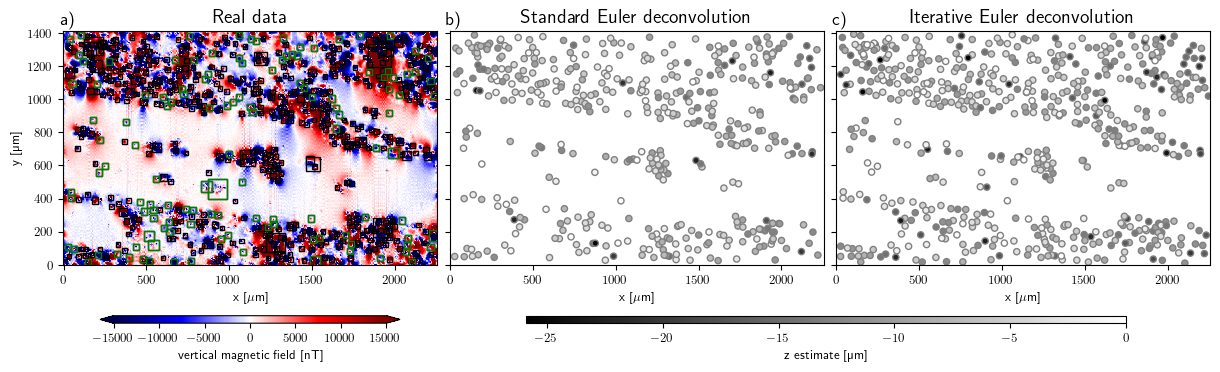

In [47]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid escape sequence '\c'
<>:197: DeprecationWarning: invalid escape sequence '\c'
<>:199: DeprecationWarning: invalid escape sequence '\c'
<>:201: DeprecationWarning: invalid escape sequence '\c'
<>:203: DeprecationWarning: invalid escape sequence '\c'
<>:206: DeprecationWarning: invalid escape sequence '\g'
<>:207: DeprecationWarning: invalid escape sequence '\g'
<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid e

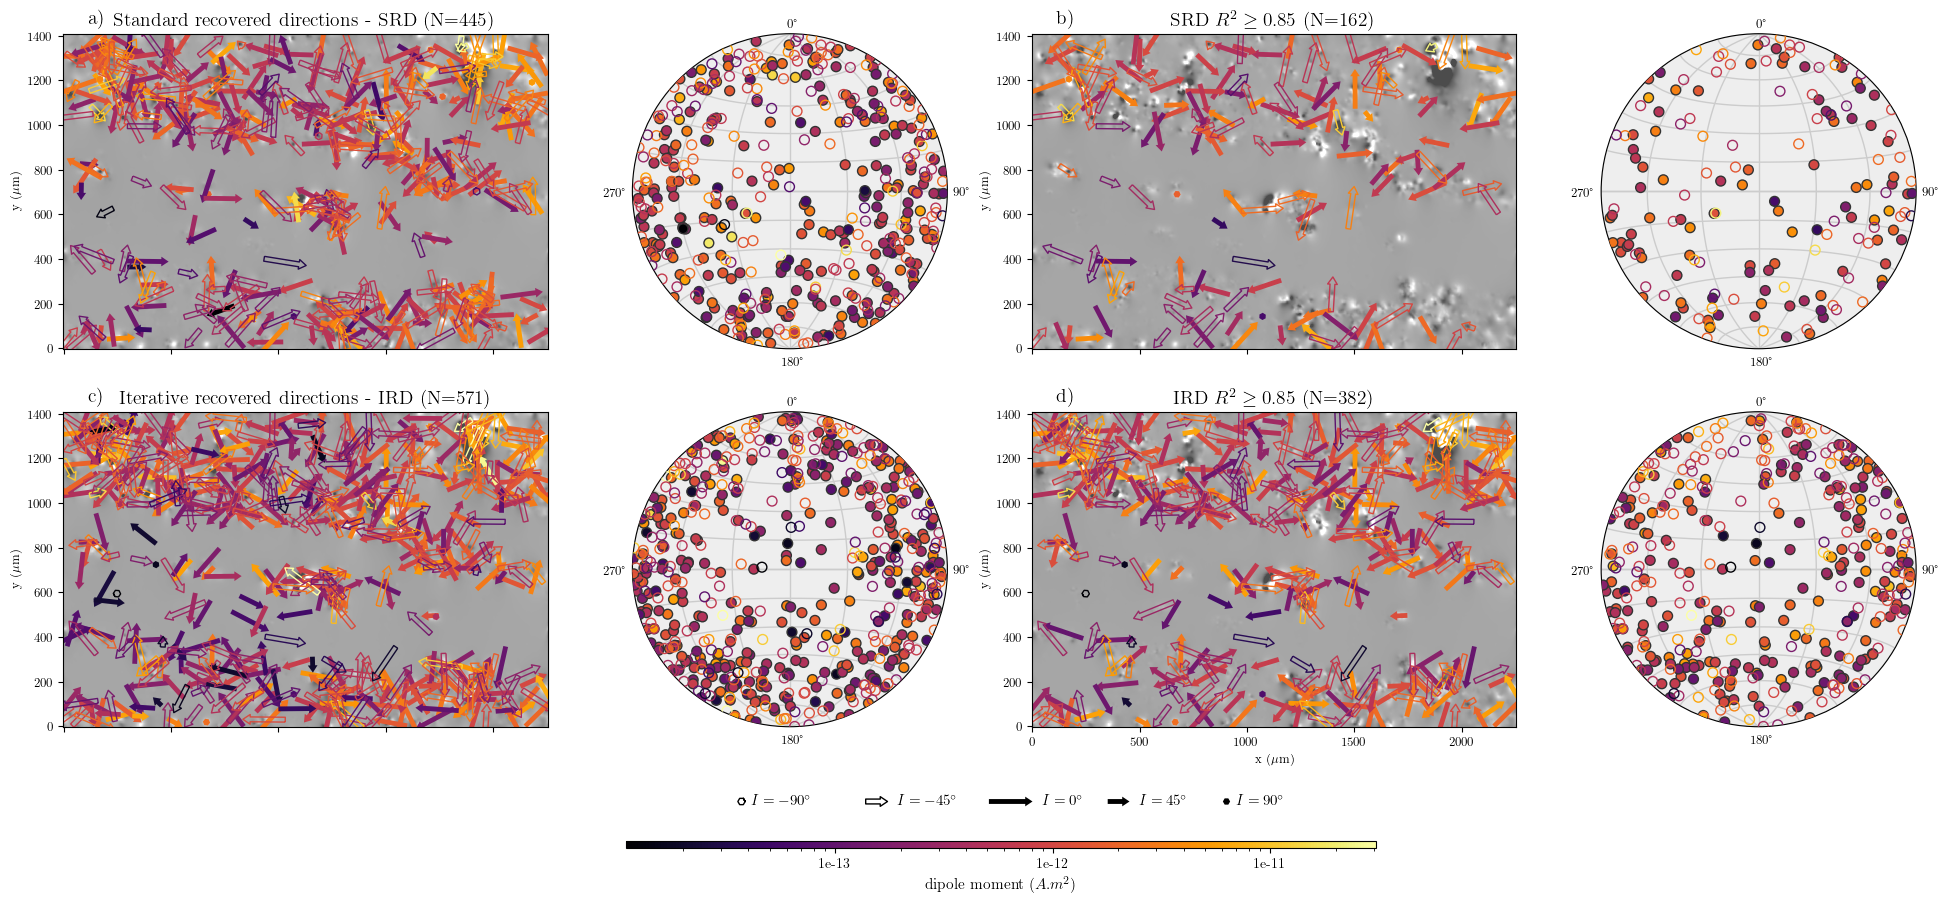

In [48]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

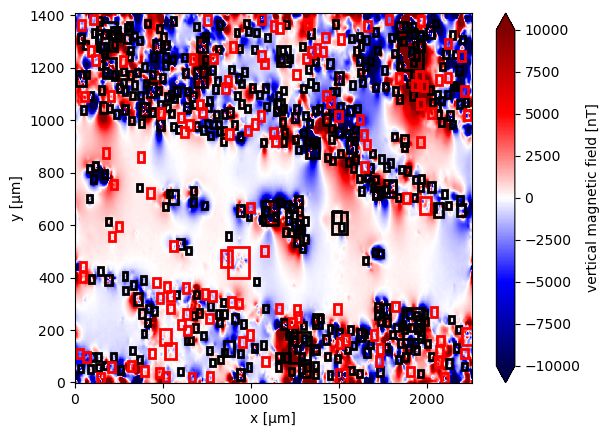

In [49]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [50]:
np.asarray(calculated_r2_itr_euler_enhanced).T

array([ 9.24631474e-01,  9.67172965e-01,  9.36620019e-01,  9.18508226e-01,
        9.71961683e-01,  9.67425237e-01,  6.85490155e-01,  9.38084314e-01,
        8.14366157e-01,  9.89003031e-01,  4.44607270e-01,  2.33093972e-01,
        9.63338959e-01,  9.76173100e-01,  9.27648168e-01,  8.30472602e-01,
        9.77670967e-01,  9.58297477e-01,  8.90971858e-01,  9.13168703e-01,
        8.93806898e-01,  9.64436252e-01,  9.73414892e-01,  5.32016687e-01,
        9.64618739e-01,  7.89229900e-03,  8.74881210e-01,  8.36407796e-01,
        9.73995083e-01,  8.98917931e-01,  8.63889619e-01,  8.54253105e-01,
        9.81839908e-01,  9.54401228e-01,  9.65006555e-01,  9.03814876e-01,
        9.40032800e-01,  9.51592761e-01,  9.43383947e-01,  9.11927828e-01,
        9.45858157e-01,  9.72513407e-01,  9.31695427e-01,  7.83820803e-01,
        9.56853203e-01,  6.97078666e-01,  9.61070557e-01,  9.46614348e-01,
        9.27412565e-01,  2.63956584e-01,  9.94000477e-01,  9.37265636e-01,
        9.07787110e-01,  

# Show the observed and predicted data

In [51]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

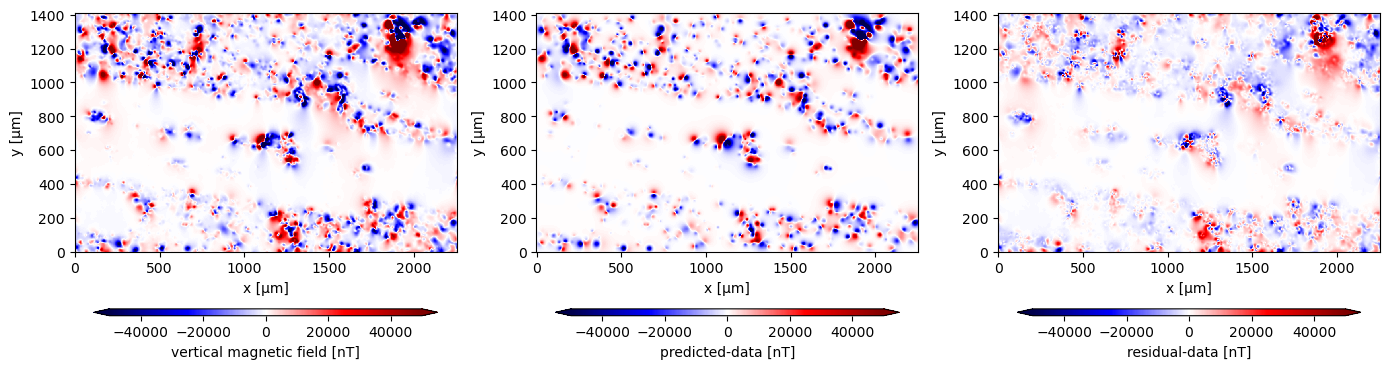

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +50000
    vmin = -50000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
Individual source:   R2 = 0.9246314738993808


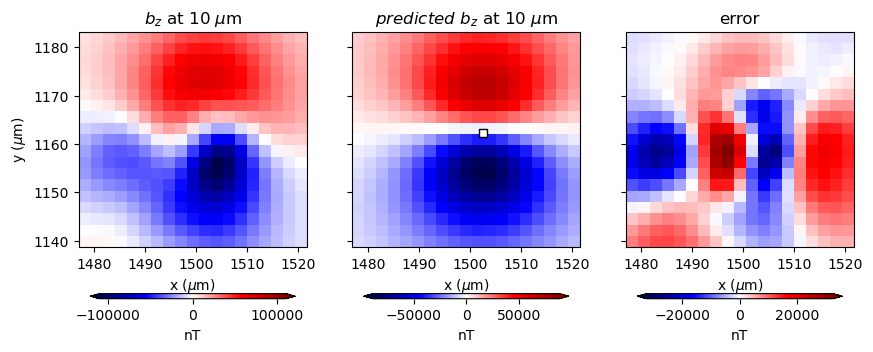

2
Individual source:   R2 = 0.9671729650279917


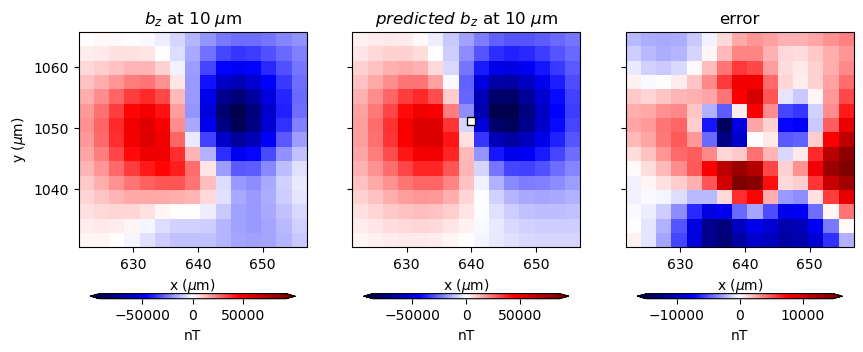

3
Individual source:   R2 = 0.9366200189178635


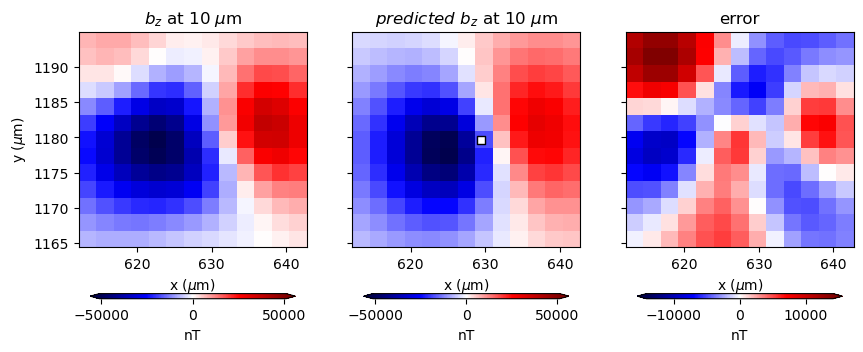

4
Individual source:   R2 = 0.9185082261267677


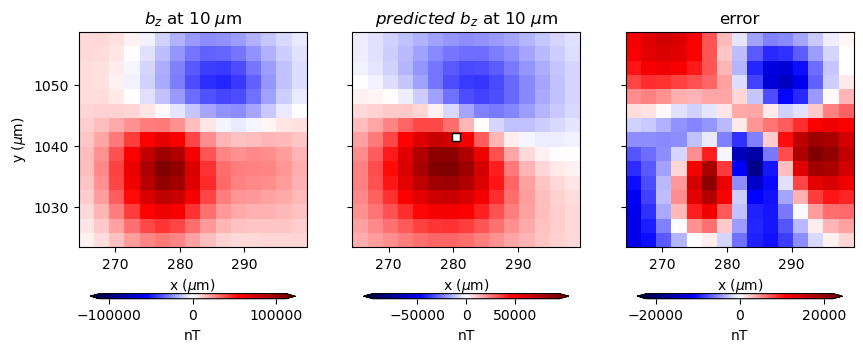

5
Individual source:   R2 = 0.9719616832258705


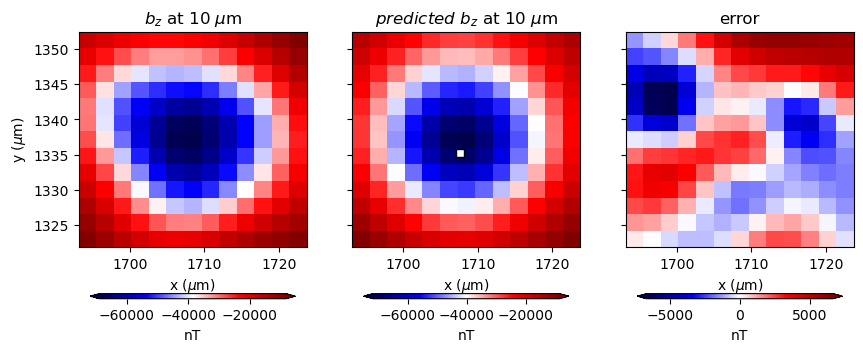

6
Individual source:   R2 = 0.9674252370648811


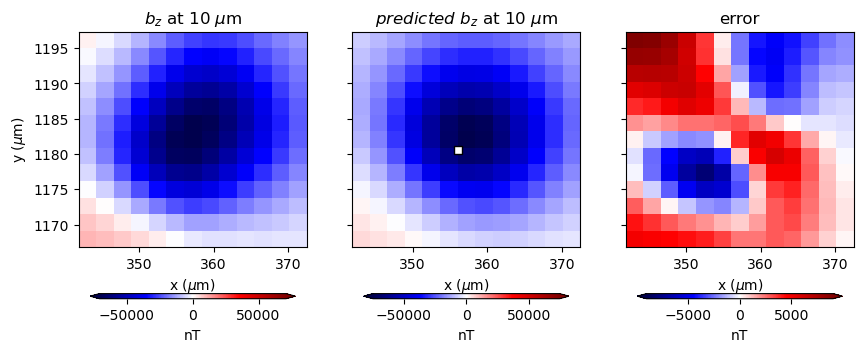

7
Individual source:   R2 = 0.6854901553278336


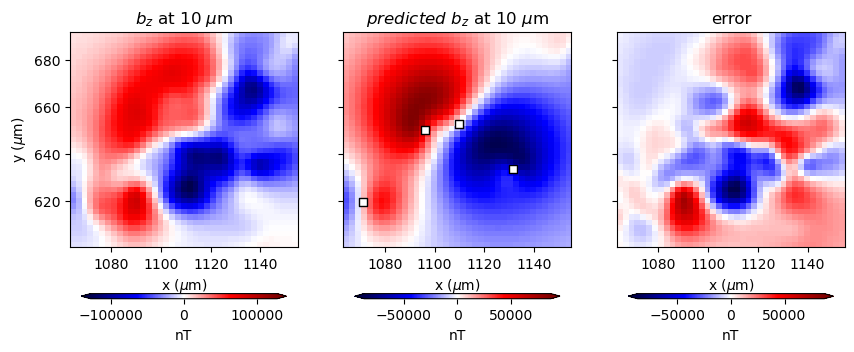

8
Individual source:   R2 = 0.9380843136628463


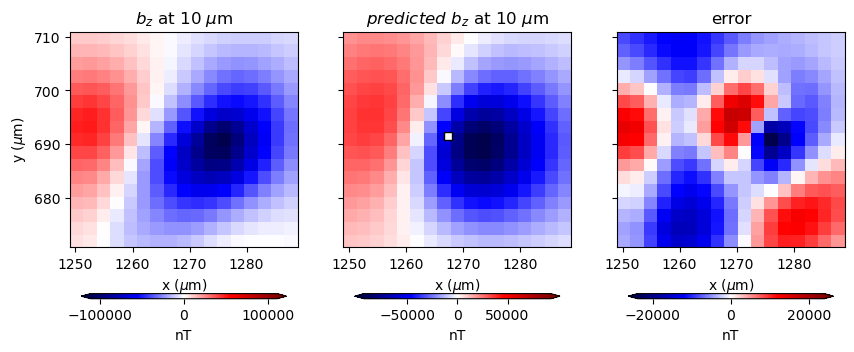

9
Individual source:   R2 = 0.814366156565688


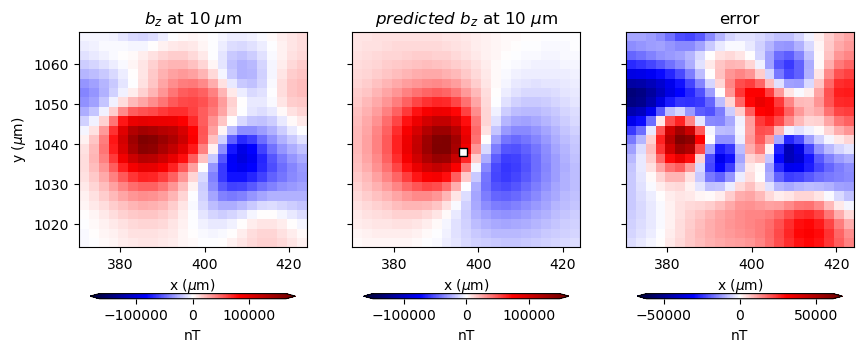

10
Individual source:   R2 = 0.9890030306902665


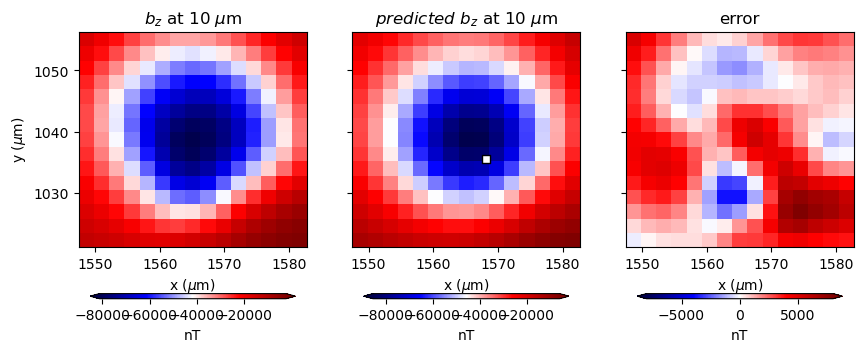

In [53]:
i = 0
slice_start=0#-20
slice_end=10#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

In [54]:
# Nome do arquivo ZIP
import os
output_folder = "csv_files_real_data"
os.makedirs(output_folder, exist_ok=True)

In [55]:
import os
# Criar um DataFrame com os vetores
standard_dataframe = pd.DataFrame({
    'mx_standard': np.asarray(estimated_dipole_moments)[:,0],
    'my_standard': np.asarray(estimated_dipole_moments)[:,1],
    'mz_standard': np.asarray(estimated_dipole_moments)[:,2],
    'r_2_standard': np.asarray(calculated_r2),
})
standard_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_standard.csv'))
standard_dataframe.to_csv(standard_csv_name, index=False)

# Criar DataFrame para os vetores iterativos
iterative_dataframe = pd.DataFrame({
    'mx_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
    'my_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
    'mz_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
    'r_2_iterative': np.asarray(calculated_r2_itr_euler_enhanced),
})

# # Salvar DataFrame iterativo como CSV
iterative_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_iterative.csv'))
iterative_dataframe.to_csv(iterative_csv_name, index=False)